In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("project2.ipynb")

In [3]:
# The pip install can take a minute
%pip install -q urllib3<2.0 otter-grader==5.5.0 datascience ipywidgets
import pyodide_http
pyodide_http.patch_all()

import otter
grader = otter.Notebook("project2.ipynb")

# Project 2: Climate Change—Temperatures and Precipitation

In this project, you will investigate data on climate change, or the long-term shifts in temperatures and weather patterns!

### Logistics

**Rules.** Don't share your code with anybody but your partner, if you have one. You are welcome to discuss questions with other students, but don't share the answers. The experience of solving the problems in this project will prepare you for exams (and life). If someone asks you for the answer, resist! Instead, you can demonstrate how you would solve a similar problem.

**Support.** You are not alone! Come to office hours and talk to your classmates. If you're ever feeling overwhelmed or don't know how to make progress, email for help.

**Tests.** The tests that are given are **not comprehensive** and passing the tests for a question **does not** mean that you answered the question correctly. Tests usually only check that your table has the correct column labels. However, more tests will be applied to verify the correctness of your submission in order to assign your final score, so be careful and check your work! You might want to create your own checks along the way to see if your answers make sense. Additionally, before you submit, make sure that none of your cells take a very long time to run (several minutes).

**Free Response Questions:** Make sure that you put the answers to the written questions in the indicated cell we provide. **Every free response question should include an explanation** that adequately answers the question. Your written work will be uploaded to Gradescope automatically after the project deadline; there is no action required on your part for this. 

**Advice.** Develop your answers incrementally. To perform a complicated task, break it up into steps, perform each step on a different line, give a new name to each result, and check that each intermediate result is what you expect. You can add any additional names or functions you want to the provided cells. Make sure that you are using distinct and meaningful variable names throughout the notebook. Along that line, **DO NOT** reuse the variable names that we use when we grade your answers. 

You **never** have to use just one line in this project or any others. Use intermediate variables and multiple lines as much as you would like!

All of the concepts necessary for this project are found in the textbook. If you are stuck on a particular problem, reading through the relevant textbook section often will help clarify the concept.


---

To get started, load `datascience`, `numpy`, and `matplotlib`. Make sure to also run the first cell of this notebook to load `otter`.

In [4]:
# Run this cell to set up the notebook, but please don't change it.
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
np.set_printoptions(legacy='1.13')

import warnings
warnings.simplefilter('ignore')


Matplotlib is building the font cache; this may take a moment.


## Part 1: Temperatures

In the following analysis, we will investigate one of the 21st century's most prominent issues: climate change. While the details of climate science are beyond the scope of this course, we can start to learn about climate change just by analyzing public records of different cities' temperature and precipitation over time.

We will analyze a collection of historical daily temperature and precipitation measurements from weather stations in 210 U.S. cities. The dataset was compiled by Yuchuan Lai and David Dzombak [1]; a description of the data from the original authors and the data itself is available [here](https://kilthub.cmu.edu/articles/dataset/Compiled_daily_temperature_and_precipitation_data_for_the_U_S_cities/7890488). 

[1] Lai, Yuchuan; Dzombak, David (2019): Compiled historical daily temperature and precipitation data for selected 210 U.S. cities. Carnegie Mellon University. Dataset.

### Part 1, Section 1: Cities

Run the following cell to load information about the `cities` and preview the first few rows.

In [3]:
cities = Table.read_table('https://raw.githubusercontent.com/data-8/materials-sp25/refs/heads/main/project/project2/city_info.csv', index_col=0)
cities.show(3)

Name,ID,Lat,Lon,Stn.Name,Stn.stDate,Stn.edDate
Lander,USW00024021,42.8153,-108.726,LANDER WBO,1892-01-01,1946-05-28
Lander,USW00024021,42.8153,-108.726,LANDER HUNT FIELD,1946-05-29,2021-12-31
Cheyenne,USW00024018,41.1519,-104.806,CHEYENNE WBO,1871-01-01,1935-08-31


The `cities` table has one row per weather station and the following columns:

1. `"Name"`: The name of the US city
2. `"ID"`: The unique identifier for the US city
3. `"Lat"`: The latitude of the US city (measured in degrees of latitude)
4. `"Lon"`: The longitude of the US city (measured in degrees of longitude)
4. `"Stn.Name"`: The name of the weather station in which the data was collected
5. `"Stn.stDate"`: A string representing the date of the first recording at that particular station
6. `"Stn.edDate"`: A string representing the date of the last recording at that particular station

The data lists the weather stations at which temperature and precipitation data were collected. Note that although some cities have multiple weather stations, only one is collecting data for that city at any given point in time. Thus, we are able to just focus on the cities themselves.

<!-- BEGIN QUESTION -->

**Question 1.1.1:** In the cell below, produce a scatter plot that plots the latitude and longitude of every city in the `cities` table so that the result places northern cities at the top and western cities at the left.

*Note*: It's okay to plot the same point multiple times!


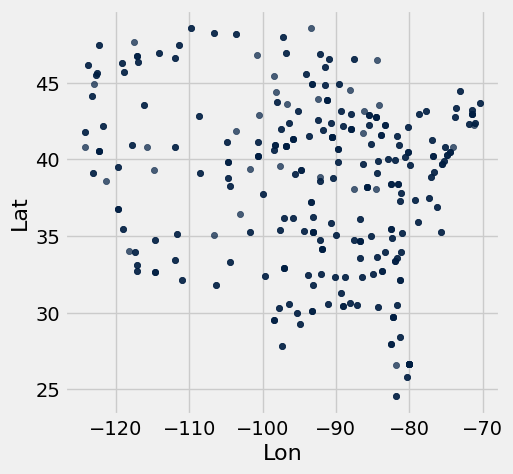

In [18]:
cities.scatter("Lon", "Lat")

<!-- END QUESTION -->

These cities are all within the continental U.S., and so the general shape of the U.S. should be visible in your plot. The shape will appear distorted compared to most maps for two reasons: the scatter plot is square even though the U.S. is wider than it is tall, and this scatter plot is an [equirectangular projection](https://en.wikipedia.org/wiki/Equirectangular_projection) of the spherical Earth. A geographical map of the same data uses the common [Pseudo-Mercator projection](https://en.wikipedia.org/wiki/Web_Mercator_projection).

In [8]:
# Just run this cell
Marker.map_table(cities.select('Lat', 'Lon', 'Name').relabeled('Name', 'labels'))

<!-- BEGIN QUESTION -->

**Question 1.1.2** Does it appear that these city locations are sampled uniformly at random from all the locations in the U.S.? Why or why not?


I don't think so. The cities in central-eastern part of US seems to be fewer than the rest.

<!-- END QUESTION -->

**Question 1.1.3:** Assign `num_unique_cities` to the number of unique cities that appear in the `cities` table.


In [10]:
num_unique_cites = cities.group("Name").num_rows

# Do not change this line
print(f"There are {num_unique_cites} unique cities that appear within our dataset.")

There are 210 unique cities that appear within our dataset.


In [11]:
grader.check("q1_1_3")

q1_1_3 results: All test cases passed!

In order to investigate further, it will be helpful to determine what region of the United States each city was located in: Northeast, Northwest, Southeast, or Southwest. For our purposes, we will be using the following geographical boundaries:

<img src= "usa_coordinates.png" alt="USA Coordinate Map" width="600"/>

1. A station is located in the `"Northeast"` region if its latitude is above or equal to 40 degrees and its longtitude is greater than or equal to -100 degrees.
2. A station is located in the `"Northwest"` region if its latitude is above or equal to 40 degrees and its longtitude is less than -100 degrees.
3. A station is located in the `"Southeast"` region if its latitude is below 40 degrees and its longtitude is greater than or equal to -100 degrees.
4. A station is located in the `"Southwest"` region if its latitude is below 40 degrees and its longtitude is less than -100 degrees.

**Question 1.1.4**: Define the `coordinates_to_region` function below. It should take in two arguments, a city's latitude (`lat`) and longitude (`lon`) coordinates, and output a string representing the region it is located in.


In [13]:
def coordinates_to_region(lat, lon):
    if lat >= 40 and lon >= -100:
        return "Northeast"
    if lat >= 40 and lon < -100:
        return "Northwest"
    if lat < 40 and lon >= -100:
        return "Southeast"
    if lat < 40 and lon < -100:
        return "Southwest"

In [14]:
grader.check("q1_1_4")

q1_1_4 results: All test cases passed!

**Question 1.1.5**: Add a new column in `cities` labeled `Region` that contains the region in which the city is located. For full credit, you must use the `coordinates_to_region` function you defined rather than reimplementing its logic.


In [15]:
regions_array = cities.apply(coordinates_to_region, "Lat", "Lon")
cities = cities.with_column("Region", regions_array)
cities.show(5)

Name,ID,Lat,Lon,Stn.Name,Stn.stDate,Stn.edDate,Region
Lander,USW00024021,42.8153,-108.726,LANDER WBO,1892-01-01,1946-05-28,Northwest
Lander,USW00024021,42.8153,-108.726,LANDER HUNT FIELD,1946-05-29,2021-12-31,Northwest
Cheyenne,USW00024018,41.1519,-104.806,CHEYENNE WBO,1871-01-01,1935-08-31,Northwest
Cheyenne,USW00024018,41.1519,-104.806,CHEYENNE MUNICIPAL ARPT,1935-09-01,2021-12-31,Northwest
Wausau,USW00014897,44.9258,-89.6256,Wausau Record Herald,1896-01-01,1941-12-31,Northeast


In [16]:
grader.check("q1_1_5")

q1_1_5 results: All test cases passed!

To confirm that you've defined your `coordinates_to_region` function correctly and successfully added the `Region` column to the `cities` table, run the following cell. Each region should have a different color in the result.

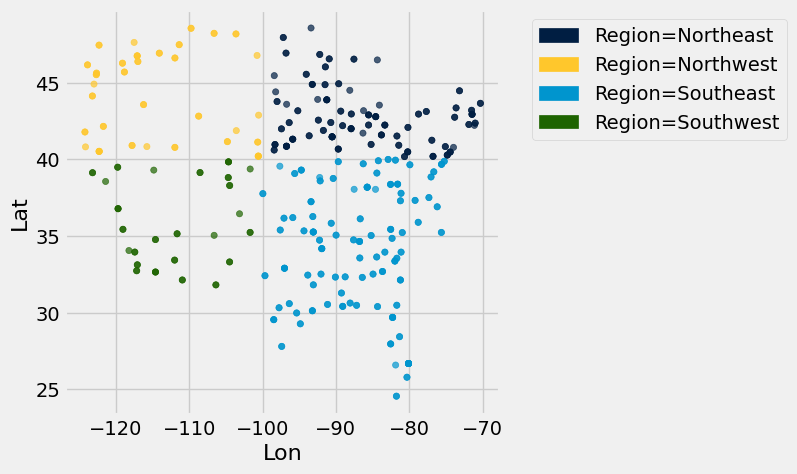

In [17]:
# Just run this cell
cities.scatter("Lon", "Lat", group="Region")

**Challenge Question 1.1.6 (OPTIONAL, ungraded)**: Create a new table called `cities_nearest`. It should contain the same columns as the `cities` table and an additional column called `"Nearest"` that contains the **name of the nearest city** that is in a different region from the city described by the row.

To approximate the distance between two cities, take the square root of the sum of the squared difference between their latitudes and the square difference between their longitudes. Don't use a `for` statement; instead, use the `apply` method and array arithmetic.

*Hint*: We have defined a `distance` function for you, which can be called on numbers `lat0` and `lon0` and arrays `lat1` and `lon1`.

In [28]:
def distance(lat0, lon0, lat1, lon1):
    "Approximate the distance between point (lat0, lon0) and (lat1, lon1) pairs in the arrays."
    return np.sqrt((lat0 - lat1) * (lat0 - lat1) + (lon0 - lon1) * (lon0 - lon1))

def nearest(name):
    row = cities.where("Name", name).row(0)
    others = cities.where("Name", are.not_equal_to(name))
    distances = distance(row.item("Lat"), row.item("Lon"), others.column("Lat"), others.column("Lon"))
    return others.with_column('dist', distances).sort('dist').row(0).item('Name')

nearest_array = cities.apply(nearest, "Name")

cities_nearest = cities.with_column("Nearest", nearest_array)
cities_nearest.show(5)

Name,ID,Lat,Lon,Stn.Name,Stn.stDate,Stn.edDate,Region,Nearest
Lander,USW00024021,42.8153,-108.726,LANDER WBO,1892-01-01,1946-05-28,Northwest,GrandJunction
Lander,USW00024021,42.8153,-108.726,LANDER HUNT FIELD,1946-05-29,2021-12-31,Northwest,GrandJunction
Cheyenne,USW00024018,41.1519,-104.806,CHEYENNE WBO,1871-01-01,1935-08-31,Northwest,Denver
Cheyenne,USW00024018,41.1519,-104.806,CHEYENNE MUNICIPAL ARPT,1935-09-01,2021-12-31,Northwest,Denver
Wausau,USW00014897,44.9258,-89.6256,Wausau Record Herald,1896-01-01,1941-12-31,Northeast,GreenBay


### Part 1, Section 2: Welcome to Phoenix, Arizona

Each city has a different CSV file full of daily temperature and precipitation measurements. The file for Phoenix, Arizona is included with this project as `phoenix.csv`. The files for other cities can be downloaded [here](https://kilthub.cmu.edu/articles/dataset/Compiled_daily_temperature_and_precipitation_data_for_the_U_S_cities/7890488) by matching them to the ID of the city in the `cities` table.

Since Phoenix is located on the upper edge of the Sonoran Desert, it has some impressive temperatures.

Run the following cell to load in the `phoenix` table. It has one row per day and the following columns:

1. `"Date"`: The date (a string) representing the date of the recording in **YYYY-MM-DD** format
2. `"tmax"`: The maximum temperature for the  day (°F)
3. `"tmin"`: The minimum temperature for the day (°F)
4. `"prcp"`: The recorded precipitation for the day (inches)

In [29]:
phoenix = Table.read_table("https://raw.githubusercontent.com/data-8/materials-sp25/refs/heads/main/project/project2/phoenix.csv", index_col=0)
phoenix.show(3)

Date,tmax,tmin,prcp
1896-01-01,66,30,0
1896-01-02,64,30,0
1896-01-03,68,30,0


**Question 1.2.1:** Assign the variable `largest_2010_range_date` to the date of the **largest temperature range** in Phoenix, Arizona for any day between January 1st, 2010 and December 31st, 2010. Your answer should be a string in the "YYYY-MM-DD" format. Feel free to use as many lines as you need. A temperature range is calculated as the difference between the max and min temperatures for the day.

*Hint*: To limit the values in a column to only those that *contain* a certain string, pick the right `are.` predicate from the [Python Reference Sheet](http://data8.org/sp22/python-reference.html).

*Note:* Do **not** re-assign the `phoenix` variable; please use the `phoenix_with_ranges_2010` variable instead.


In [42]:
def temperature_range(tmax, tmin):
    return abs(tmax - tmin)
phoenix_with_ranges_2010 = (phoenix
                            .where("Date", are.between("2010-01-01", "2010-12-31"))
                            .with_column("tempRange", phoenix_with_ranges_2010.apply(temperature_range, "tmax", "tmin"))
                           )
largest_2010_range_date = phoenix_with_ranges_2010.sort("tempRange", descending=True).column("Date").item(0)
largest_2010_range_date

'2010-06-24'

In [43]:
grader.check("q1_2_1")

q1_2_1 results: All test cases passed!

We can look back to our `phoenix` table to check the temperature readings for our `largest_2010_range_date` to see if anything special is going on. Run the cell below to find the row of the `phoenix` table that corresponds to the date we found above. 

In [44]:
# Just run this cell
phoenix.where("Date", largest_2010_range_date)

Date,tmax,tmin,prcp
2010-06-24,113,79,0


ZOO WEE MAMA! Look at the maximum temperature for that day. That's hot.

The function `extract_year_from_date` takes a date string in the **YYYY-MM-DD** format and returns an integer representing the **year**. The function `extract_month_from_date` takes a date string and returns a string describing the month. Run this cell, but you do not need to understand how this code works or edit it.

In [45]:
# Just run this cell
import calendar

def extract_year_from_date(date):
    """Returns an integer corresponding to the year of the input string's date."""
    return int(date[:4])

def extract_month_from_date(date):
    "Return an abbreviation of the name of the month for a string's date."
    month = date[5:7]
    return f'{month} ({calendar.month_abbr[int(date[5:7])]})'


# Example
print('2022-04-01 has year', extract_year_from_date('2022-04-01'),
      'and month', extract_month_from_date('2022-04-01'))

2022-04-01 has year 2022 and month 04 (Apr)


**Question 1.2.2:** Add two new columns called `Year` and `Month` to the `phoenix` table that contain the year as an **integer** and the month as a **string** (such as `"04 (Apr)"`) for each day, respectively. 

*Note*: The functions above may be helpful!


In [46]:
years_array = phoenix.apply(extract_year_from_date, "Date")
months_array = phoenix.apply(extract_month_from_date, "Date")
phoenix = (phoenix
          .with_columns("Year", years_array, "Month", months_array)
          )
phoenix.show(5)

Date,tmax,tmin,prcp,Year,Month
1896-01-01,66,30,0,1896,01 (Jan)
1896-01-02,64,30,0,1896,01 (Jan)
1896-01-03,68,30,0,1896,01 (Jan)
1896-01-04,69,34,0,1896,01 (Jan)
1896-01-05,70,46,0,1896,01 (Jan)


In [47]:
grader.check("q1_2_2")

q1_2_2 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 1.2.3:** Using the `phoenix` table, create an overlaid line plot of the **average maximum temperature** and **average minimum temperature** for each year between 1900 and 2020 (inclusive). 

*Hint:* To draw a line plot with more than one line, call `plot` on the column label of the x-axis values and all other columns will be treated as y-axis values.


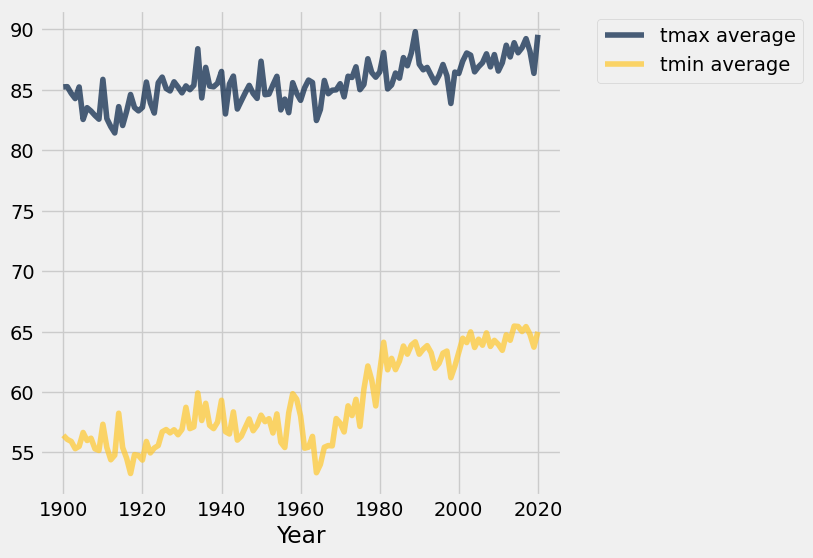

In [52]:
phoenix_group_by_year = (phoenix
                        .select("Year", "tmax", "tmin")
                        .group("Year", np.average)
                        )
phoenix_bet_1900_to_2020 = phoenix_group_by_year.where("Year", are.between(1900, 2021))
phoenix_bet_1900_to_2020.plot("Year")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 1.2.4:** Although still hotly debated (pun intended), many climate scientists agree that the effects of climate change began to surface in the early 1960s as a result of elevated levels of greenhouse gas emissions. How does the graph you produced in Question 1.2.3 support the claim that modern-day global warming began in the early 1960s? 


The average temperature of maximum and minimum keeps getting higher and higher after earlys 1960.

<!-- END QUESTION -->

Averaging temperatures across an entire year can obscure some effects of climate change. For example, if summers get hotter but winters get colder, the annual average may not change much. Let's investigate how average **monthly** maximum temperatures have changed over time in Phoenix. 

**Question 1.2.5:** Create a `monthly_increases` table with one row per month and the following four columns in order: 
1. `"Month"`: The month (such as `"02 (Feb)"`)
2. `"Past"`: The average max temperature in that month from 1900-1960 (inclusive)
3. `"Present"`: The average max temperature in that month from 2019-2021 (inclusive)
4. `"Increase"`: The difference between the present and past average max temperatures in that month

First make a copy of the `phoenix` table and add a new column containing the corresponding **period** for each row. You may find the `period` function helpful. Then, use this new table to construct `monthly_increases`. Feel free to use as many lines as you need.

*Hint*: What table method can we use to get each **unique value** as its own column? 

*Note*: Please do **not** re-assign the `phoenix` variable!


In [90]:
def period(year):
    "Output if a year is in the Past, Present, or Other."
    if 1900 <= year <= 1960:
        return "Past"
    elif 2019 <= year <= 2021:
        return "Present"
    else:
        return "Other"
    
phoenix_with_period = (phoenix.with_column("Period", phoenix.apply(period, "Year")))
filtered = phoenix_with_period.where("Period", are.not_equal_to("Other"))
filtered = filtered.drop("Date", "prcp", "Year", "tmin")
phoenix_max_temps = filtered.pivot("Period", "Month", values="tmax", collect=np.average)
monthly_increases = (phoenix_max_temps
                    .with_column("Increase", phoenix_max_temps.column("Present") - phoenix_max_temps.column("Past"))
                    )
monthly_increases.show()

Month,Past,Present,Increase
01 (Jan),65.0164,67.8312,2.81479
02 (Feb),68.8485,69.1859,0.337362
03 (Mar),74.6499,75.9796,1.32965
04 (Apr),82.6421,88.4,5.75792
05 (May),91.4299,94.571,3.14104
06 (Jun),101.166,105.734,4.56832
07 (Jul),103.599,107.245,3.64654
08 (Aug),101.416,107.384,5.96769
09 (Sep),97.6874,101.238,3.55035
10 (Oct),86.798,90.1667,3.36868


In [87]:
grader.check("q1_2_5")

q1_2_5 results: All test cases passed!

### February in Phoenix

The `"Past"` column values are averaged over many decades, and so they are reliable estimates of the average high temperatures in those months before the effects of modern climate change. However, the `"Present"` column is based on only three years of observations. February, the shortest month, has the fewest total observations: only 85 days. Run the following cell to see this.

In [88]:
# Just run this cell
feb_present = phoenix.where('Year', are.between_or_equal_to(2019, 2021)).where('Month', '02 (Feb)')
feb_present.num_rows

85

Look back to your `monthly_increases` table. Compared to the other months, the increase for the month of February is quite small; the February difference is very close to zero. Run the following cell to print out our observed difference.

In [91]:
# Just run this cell
print(f"February Difference: {monthly_increases.row(1).item('Increase')}")

February Difference: 0.3373623297258632


Perhaps that small difference is somehow due to chance! To investigate this idea requires a thought experiment.

We can observe all of the February maximum temperatures from 2019 to 2021 (the present period), so we have access to the census; there's no random sampling involved. But, we can imagine that if more years pass with the same present-day climate, there would be different but similar maximum temperatures in future February days. From the data we observe, we can try to estimate the **average maximum February temperature** in this imaginary collection of all future February days that would occur in our modern climate, assuming the climate doesn't change any further and many years pass.

We can also imagine that the maximum temperature each day is like a **random draw from a distribution of temperatures for that month**. Treating actual observations of natural events as if they were each *randomly* sampled from some unknown distribution is a simplifying assumption. These temperatures were not actually sampled at random—instead they occurred due to the complex interactions of the Earth's climate—but treating them as if they were random abstracts away the details of this naturally occuring process and allows us to carry out statistical inference.  Conclusions are only as valid as the assumptions upon which they rest, but in this case thinking of daily temperatures as random samples from some unknown climate distribution seems at least plausible.

If we assume that the **actual temperatures were drawn at random from some large population of possible February days** in our modern climate, then we can not only estimate the population average of this distribution, but also quantify our uncertainty about that estimate using a confidence interval.

**We will just compute the lower bound of this confidence interval.** The upper bound of a confidence interval for a population average based on a sample is always larger than the sample average. We intend to compare our confidence interval to the historical average (ie. the `Past` value in our `monthly_increases` table). In all months, the sample average we will consider (i.e. the `Present` value in our `monthly_increases` table) is larger than the historical average. As a result, we know in advance that the upper bound of the confidence interval will be larger as well, and there is no need to compute the upper bound explicitly. (But you can if you wish!)

**Question 1.2.6.** Complete the implementation of the function `ci_lower`, which takes a one-column table `t` containing sample observations and a confidence `level` percentage such as 95 or 99. It returns the lower bound of a confidence interval for the population mean constructed using 5,000 bootstrap resamples.

After defining `ci_lower`, we have provided a line of code that calls `ci_lower` on the present-day February max temperatures to output the lower bound of a 99% confidence interval for the February average max temperature. The result should be around 67 degrees.


In [103]:
def ci_lower(t, level):
    """Compute a lower bound of a level% confidence interval of the 
    average of the population for which column 0 of Table t contains a sample.
    """
    stats = make_array()
    for k in np.arange(5000):
        stat = np.mean(t.sample().column(0))
        stats = np.append(stats, stat)
    return percentile((100 - level) / 2, stats)

# Call ci_lower on the max temperatures in present-day February to find the lower bound of a 99% confidence interval.
feb_present_ci = ci_lower(feb_present.select('tmax'), 99)
feb_present_ci

66.977647058823507

In [104]:
grader.check("q1_2_6")

q1_2_6 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 1.2.7** The lower bound of the `feb_present_ci` 99% confidence interval is below the observed past February average maximum temperature of 68.8485 (from the `monthly_increases` table). What conclusion can you draw about the effect of climate change on February maximum temperatures in Phoenix from this information? Use a 1% p-value cutoff.

*Note*: If you're stuck on this question, re-reading the paragraphs under the *February* heading (particularly the first few) may be helpful.


Since the historical average (68.8485°F) lies within the 99% confidence interval for the present-day average, we fail to reject the null hypothesis at the 1% significance level.

<!-- END QUESTION -->

### All Months

**Question 1.2.8.** Repeat the process of comparing the **lower bound of a 99% confidence interval** to the **past average** for each month. For each month, print out the name of the month (e.g., `02 (Feb)`), the observed past average, and the lower bound of a confidence interval for the present average.

Use the provided call to `print` in order to format the result as one line per month.

*Hint*: Your code should follow the same format as our code from above (i.e. the *February* section).   


In [107]:
comparisons = make_array()
months = phoenix.group("Month").column("Month")
for month in months:
    past_average = monthly_increases.where("Month", month).row(0).item("Past")
    present_observations = phoenix.where('Year', are.between_or_equal_to(2019, 2021)).where('Month', month)
    present_lower_bound = ci_lower(present_observations.select("tmax"), 99)
    
    # Do not change the code below this line
    below = past_average < present_lower_bound
    if below:
        comparison = '**below**'
    else:
        comparison = '*above*'
    comparisons = np.append(comparisons, comparison)
    
    print('For', month, 'the past avg', round(past_average, 1), 
          'is', comparison, 
          'the lower bound', round(present_lower_bound, 1),
          'of the 99% CI of the present avg. \n')

For 01 (Jan) the past avg 65.0 is **below** the lower bound 66.3 of the 99% CI of the present avg. 

For 02 (Feb) the past avg 68.8 is *above* the lower bound 67.0 of the 99% CI of the present avg. 

For 03 (Mar) the past avg 74.6 is *above* the lower bound 74.0 of the 99% CI of the present avg. 

For 04 (Apr) the past avg 82.6 is **below** the lower bound 86.4 of the 99% CI of the present avg. 

For 05 (May) the past avg 91.4 is **below** the lower bound 92.5 of the 99% CI of the present avg. 

For 06 (Jun) the past avg 101.2 is **below** the lower bound 104.3 of the 99% CI of the present avg. 

For 07 (Jul) the past avg 103.6 is **below** the lower bound 105.5 of the 99% CI of the present avg. 

For 08 (Aug) the past avg 101.4 is **below** the lower bound 105.7 of the 99% CI of the present avg. 

For 09 (Sep) the past avg 97.7 is **below** the lower bound 99.4 of the 99% CI of the present avg. 

For 10 (Oct) the past avg 86.8 is **below** the lower bound 87.8 of the 99% CI of the pre

In [108]:
grader.check("q1_2_8")

q1_2_8 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 1.2.9.** Summarize your findings. After comparing the past average to the 99% confidence interval's lower bound for each month, what conclusions can we make about the monthly average maximum temperature in historical (1900-1960) vs. modern (2019-2021) times in the twelve months? In other words, what null hypothesis should you consider, and for which months would you reject or fail to reject the null hypothesis? Use a 1% p-value cutoff.

*Hint*: Do you notice any seasonal patterns?


9 out of 12 months show a statistically significant increase in average max temperatures compared to the early 20th century.

February, March, and December show no significant difference, meaning modern temps in those months are not definitively higher.

This pattern suggests a seasonal trend: summer and fall months show stronger warming, while winter months (like Feb & Dec) show weaker or non-significant changes.

<!-- END QUESTION -->

### Congratulations

Congratulations, you made it this far!


--- 
The cell below will re-run all of the autograder tests for Part 1 to double check your work.

In [109]:
checkpoint_tests = ["q1_1_3", "q1_1_4", "q1_1_5",
                    "q1_2_1", "q1_2_2", "q1_2_5", "q1_2_6", "q1_2_8"]

for test in checkpoint_tests:
    display(grader.check(test))

q1_1_3 results: All test cases passed!

q1_1_4 results: All test cases passed!

q1_1_5 results: All test cases passed!

q1_2_1 results: All test cases passed!

q1_2_2 results: All test cases passed!

q1_2_5 results: All test cases passed!

q1_2_6 results: All test cases passed!

q1_2_8 results: All test cases passed!

## Submission
If your instructor would like you to submit the work in part one as a checkpoint to the project, follow the instructions below.

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Your instructor may want you to submit your work thus far as a checkpoint.

**Reminders**:
- Make sure to wait until the autograder finishes running to ensure that your submission was processed properly and that you submitted to the correct assignment.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)

# Part 2: Drought

According to the [United States Environmental Protection Agency](https://www.epa.gov/climate-indicators/southwest), "Large portions of the Southwest have experienced drought conditions since weekly Drought Monitor records began in 2000. For extended periods from 2002 to 2005 and from 2012 to 2020, nearly the entire region was abnormally dry or even drier." 

Assessing the impact of drought is challenging with just city-level data because so much of the water that people use is transported from elsewhere, but we'll explore the data we have and see what we can learn.

Let's first take a look at the precipitation data in the Southwest region. The `southwest.csv` file contains total annual precipitation for 13 cities in the southwestern United States for each year from 1960 to 2021. This dataset is aggregated from the daily data and includes only the Southwest cities from the original dataset that have consistent precipitation records back to 1960.

In [5]:
southwest = Table.read_table('https://raw.githubusercontent.com/data-8/materials-fds/refs/heads/main/project/project2/southwest.csv')
southwest.show(5)

City,Year,Total Precipitation
Albuquerque,1960,8.12
Albuquerque,1961,8.87
Albuquerque,1962,5.39
Albuquerque,1963,7.47
Albuquerque,1964,7.44


**Question 2.1.** Create a table `totals` that has one row for each year in chronological order. It should contain the following columns:
1. `"Year"`: The year (a number)
2. `"Precipitation"`: The total precipitation in all 13 southwestern cities that year


In [17]:
totals = (southwest
         .drop("City")
         .group("Year", np.sum)
         .sort("Year")
         .relabeled("Total Precipitation sum", "Precipitation")
         )
totals

Year,Precipitation
1960,149.58
1961,134.82
1962,130.41
1963,132.18
1964,123.41
1965,187.53
1966,120.27
1967,179.02
1968,136.25
1969,191.72


In [18]:
grader.check("q2_1")

q2_1 results: All test cases passed!

Run the cell below to plot the total precipitation in these cities over time, so that we can try to spot the drought visually. As a reminder, the drought years given by the EPA were  (2002-2005) and (2012-2020).

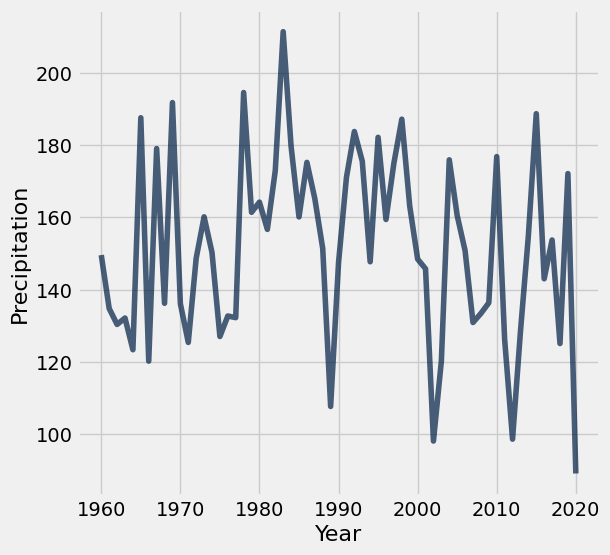

In [19]:
# Just run this cell
totals.plot("Year", "Precipitation")

This plot isn't very revealing. Each year has a different amount of precipitation, and there is quite a bit of variability across years, as if each year's precipitation is a random draw from a distribution of possible outcomes. 

Could it be that these so-called "drought conditions" from 2002-2005 and 2012-2020 can be explained by chance? In other words, could it be that the annual precipitation amounts in the Southwest for these drought years are like **random draws from the same underlying distribution** as for other years? Perhaps nothing about the Earth's precipitation patterns has really changed, and the Southwest U.S. just happened to experience a few dry years close together. 

To assess this idea, let's conduct an A/B test in which **each year's total precipitation** is an outcome, and the condition is **whether or not the year is in the EPA's drought period**.

This `drought_label` function distinguishes between drought years as described in the U.S. EPA statement above (2002-2005 and 2012-2020) and other years. Note that the label "other" is perhaps misleading, since there were other droughts before 2000, such as the massive [1988 drought](https://en.wikipedia.org/wiki/1988%E2%80%9390_North_American_drought) that affected much of the U.S. However, if we're interested in whether these modern drought periods (2002-2005 and 2012-2020) are *normal* or *abnormal*, it makes sense to distinguish the years in this way. 

In [20]:
def drought_label(n):
    """Return the label for an input year n."""
    if 2002 <= n <= 2005 or 2012 <= n <= 2020:
        return 'drought'
    else:
        return 'other'

<!-- BEGIN QUESTION -->

**Question 2.2.** Define null and alternative hypotheses for an A/B test that investigates whether drought years are drier (have less precipitation) than other years.

*Note:* Please format your answer using the following structure.

- *Null hypothesis:* ...
- *Alternative hypothesis:* ...


Null hypothesis: In the population, the distribution of annual precipitation during drought years is the same as during non-drought years. Any observed difference in the sample is due to chance.
Alternative hypothesis: In the population, drought years have lower precipitation than non-drought years.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2.3.** First, define the table `drought`. It should contain one row per year and the following two columns:
- `"Label"`: Denotes if a year is part of a `"drought"` year or an `"other"` year
- `"Precipitation"`: The sum of the total precipitation in 13 Southwest cities that year

Then, construct an overlaid histogram of two observed distributions: the total precipitation in drought years and the total precipitation in other years. 

*Note*: Use the provided `bins` when creating your histogram, and do not re-assign the `southwest` table. Feel free to use as many lines as you need!

*Hint*: The optional `group` argument in a certain function might be helpful!


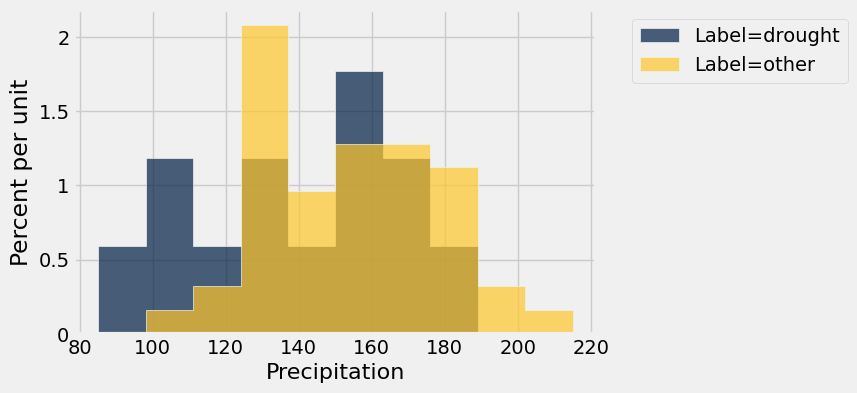

In [30]:
bins = np.arange(85, 215+1, 13)
drought = (Table()
          .with_columns(
              "Label", totals.apply(drought_label, "Year"),
              "Precipitation", totals.column("Precipitation")
          )
        )
drought.hist("Precipitation", group="Label", bins=bins)

<!-- END QUESTION -->

Before you continue, inspect the histogram you just created and try to guess the conclusion of the A/B test. Building intuition about the result of hypothesis testing from visualizations is quite useful for data science applications. 

**Question 2.4.** Our next step is to choose a test statistic based on our alternative hypothesis in Question 2.2. Which of the following options are valid choices for the test statistic? Assign `ab_test_stat` to an array of integers corresponding to valid choices. Assume averages and totals are taken over the total precipitation sums for each year.

1. The difference between the **total** precipitation in **drought** years and the **total** precipitation in **other** years.
2. The difference between the **total** precipitation in **others** years and the **total** precipitation in **drought** years.
3. The **absolute** difference between the **total** precipitation in others years and the **total** precipitation in drought years.
1. The difference between the **average** precipitation in **drought** years and the **average** precipitation in **other** years.
2. The difference between the **average** precipitation in **others** years and the **average** precipitation in **drought** years.
3. The **absolute** difference between the **average** precipitation in others years and the **average** precipitation in drought years.


In [35]:
ab_test_stat = make_array(1, 2, 4, 5)

In [36]:
grader.check("q2_4")

q2_4 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 2.5.** Fellow climate scientists Olivia and Will point out that there are more **other** years than **drought** years, and so measuring the difference between total precipitation will always favor the **other** years. They conclude that all of the options above involving **total** precipitation are invalid test statistic choices. Do you agree with them? Why or why not?


Yes, I agree with Olivia and Will. When the number of years differs between drought and non-drought periods, using total precipitation as a test statistic is invalid because it confounds the comparison — the difference in totals reflects both precipitation amounts and the number of years. A valid test statistic should use average precipitation to make a fair, unbiased comparison.

<!-- END QUESTION -->

Before going on, check your `drought` table. It should have two columns `Label` and `Precipitation` with 61 rows, 13 of which are for `"drought"` years.

In [26]:
drought.show(3)

Label,Precipitation
other,149.58
other,134.82
other,130.41


In [27]:
drought.group('Label')

Label,count
drought,13
other,48


**Question 2.6.** For our A/B test, we'll use the difference between the average precipitation in drought years and the average precipitation in other years as our test statistic:

$$\text{average precipitation in "drought" years} - \text{average precipitation in "other" years}$$

First, complete the function `test_statistic`. It should take in a two-column table `t` with one row per year and two columns:
- `Label`: the label for that year (either `'drought'` or `'other'`)
- `Precipitation`: the total precipitation in the 13 Southwest cities that year. 

Then, use the function you define to assign `observed_statistic` to the observed test statistic.


In [28]:
def test_statistic(t):
    avg_drought_years = np.mean(t.where("Label", "drought").column("Precipitation"))
    avg_other_years = np.mean(t.where("Label", "other").column("Precipitation"))
    return avg_drought_years - avg_other_years

observed_statistic = test_statistic(drought)
observed_statistic

-15.856714743589748

In [29]:
grader.check("q2_6")

q2_6 results: All test cases passed!

Now that we have defined our hypotheses and test statistic, we are ready to conduct our hypothesis test. We’ll start by defining a function to simulate the test statistic under the null hypothesis, and then call that function 5,000 times to construct an empirical distribution under the null hypothesis.

**Question 2.7.** Write a function to simulate the test statistic under the null hypothesis. The `simulate_precipitation_null` function should simulate the null hypothesis once (not 5,000 times) and return the value of the test statistic for that simulated sample.

*Hint*: Using `t.with_column(...)` with a column name that already exists in a table `t` will replace that column with the newly specified values.


In [39]:
def simulate_precipitation_null():
    shuffled_labels = drought.sample(with_replacement=False).column("Label")
    shuffled_table = drought.with_column("Label", shuffled_labels)
    return test_statistic(shuffled_table)

# Run your function a couple times to make sure that it works
simulate_precipitation_null()

-9.6384294871795078

In [40]:
grader.check("q2_7")

q2_7 results: All test cases passed!

**Question 2.8.** Fill in the blanks below to complete the simulation for the hypothesis test. Your simulation should compute 5,000 values of the test statistic under the null hypothesis and store the result in the array `sampled_stats`.

*Hint:* You should use the `simulate_precipitation_null` function you wrote in the previous question!

*Note:* Running this cell may take a few seconds. If it takes more than a minute, try to find a faster way to implement your `simulate_precipitation_null` function.


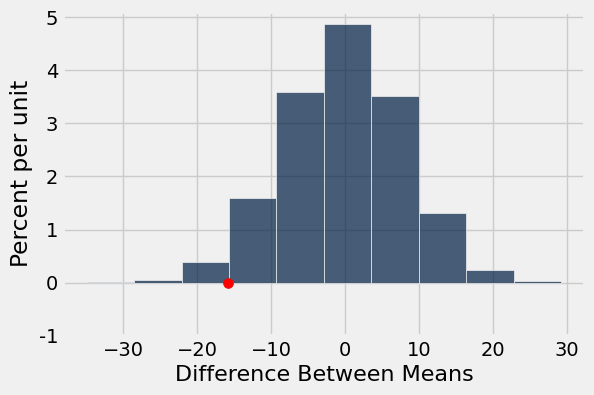

In [41]:
sampled_stats = make_array()

repetitions = 5000
for i in np.arange(repetitions):
    stat = simulate_precipitation_null()
    sampled_stats = np.append(sampled_stats, stat)

# Do not change these lines
Table().with_column('Difference Between Means', sampled_stats).hist()
plt.scatter(observed_statistic, 0, c="r", s=50);
plt.ylim(-0.01);

In [42]:
grader.check("q2_8")

q2_8 results: All test cases passed!

**Question 2.9.** Compute the p-value for this hypothesis test, and assign it to the variable `precipitation_p_val`.


In [50]:
precipitation_p_val = np.count_nonzero(sampled_stats <= observed_statistic) / repetitions
precipitation_p_val

0.027

In [51]:
grader.check("q2_9")

q2_9 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 2.10.** State a conclusion from this test using a p-value cutoff of 5%. What have you learned about the EPA's statement on drought?


At the 5% significance level, we reject the null hypothesis and conclude that there is evidence that drought years had lower average annual precipitation than non-drought years. This supports the EPA’s claim that those periods represent genuine drought conditions rather than random variation.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2.11.** Does your conclusion from Question 2.10 apply to the entire Southwest region of the U.S.? Why or why not?


The conclusion from Question 2.10 only applies to the region or data sampled in the analysis. Unless the precipitation data represents the entire Southwest U.S., we cannot confidently generalize the results to the entire region. Broader conclusions would require data that is spatially representative of the full Southwest area.

<!-- END QUESTION -->

# Conclusion

Data science plays a central role in climate change research because massive simulations of the Earth's climate are necessary to assess the implications of climate data recorded from weather stations, satellites, and other sensors. [Berkeley Earth](http://berkeleyearth.org/data/) is a common source of data for these kinds of projects.

In this project, we found ways to apply our statistical inference technqiues that rely on random sampling even in situations where the data were not generated randomly, but instead by some complicated natural process that appeared random. We made assumptions about randomness and then came to conclusions based on those assumptions. Great care must be taken to choose assumptions that are realistic, so that the resulting conclusions are not misleading. However, making assumptions about data can be productive when doing so allows inference techniques to apply to novel situations.

**Congratulations on finishing Project 2! Time to submit.**

**Important submission steps:** 
1. Run the tests and verify that they all pass.
2. Choose **Save Notebook** from the **File** menu, then **run the final cell**. 
3. Click the link to download the zip file.
4. Then submit the zip file to the corresponding assignment according to your instructor's directions. 

**It is your responsibility to make sure your work is saved before running the last cell.**

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)